<a href="https://colab.research.google.com/github/jihyeon602/ETRI_lifelog_dataset/blob/main/ETRI_%ED%95%98%EB%A3%A8%EB%8B%A8%EC%9C%84(ratio_%EC%B6%94%EA%B0%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 경로지정, parquet 파일 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. 실험 재현을 위한 Seed 고정 (가장 맨 위에 둬야 함)
import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()  # TensorFlow 2.9 이상에서만

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import mode
from scipy import stats
from datetime import timedelta
from tqdm import tqdm

# Note: Set the file path associated with the dataset.
challenge2025_dataset_path = '/content/drive/MyDrive/Sleep/ch2025_data_items'

# To print the list of data items
print("challenge 2025 dataset " + "="*5,'\n')
for file_name in sorted(os.listdir(challenge2025_dataset_path)):
    if file_name.endswith('.parquet'):
        print(file_name)

challenge 2025 dataset ===== 

ch2025_mACStatus.parquet
ch2025_mActivity.parquet
ch2025_mAmbience.parquet
ch2025_mBle.parquet
ch2025_mGps.parquet
ch2025_mLight.parquet
ch2025_mScreenStatus.parquet
ch2025_mUsageStats.parquet
ch2025_mWifi.parquet
ch2025_wHr.parquet
ch2025_wLight.parquet
ch2025_wPedo.parquet


# 데이터 전처리

### 1. mACStatus, 하루단위
- 충전 총횟수, ratio만 남김

In [20]:
# 1. 파일 경로
data_item = "mACStatus"
input1 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 하루 단위로 집계하는 함수 정의
def process_mACStatus_ratio_transitions(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(['subject_id', 'timestamp'])

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_charging'].values  # 0/1 충전 상태

        # 충전 비율
        ratio_charging = status.mean()

        # 충전/비충전 상태 전환 횟수
        transitions = (status[1:] != status[:-1]).sum()

        results.append({
            'subject_id': subj,
            'date': date,
            'charging_transitions': transitions,
            'charging_ratio': ratio_charging
        })

    return pd.DataFrame(results)


# 3. 변환 실행
input1_daily = process_mACStatus_ratio_transitions(input1)


In [22]:
input1_daily.head()

,subject_id,date,charging_transitions,charging_ratio
0,id01,2024-06-26,22,0.215859
1,id01,2024-06-27,32,0.158571
2,id01,2024-06-28,29,0.180282
3,id01,2024-06-29,3,0.286567
4,id01,2024-06-30,8,0.144286


### 2. mActivity, 하루단위
- 원핫인코딩 유지

In [23]:
# 1. 파일 경로
data_item = "mActivity"  # 사용자 활동 상태
input2 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 원핫 인코딩
activity_ohe = pd.get_dummies(input2['m_activity'], prefix='activity').astype(int)
input2 = pd.concat([input2[['subject_id', 'timestamp']], activity_ohe], axis=1)

# 3. 하루 단위로 집계하는 함수 정의
def process_mActivity_ohe_daily(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    # 하루 단위 평균값 (각 activity의 비율)
    daily_summary = (
        df.groupby(['subject_id', 'date'])
        .mean(numeric_only=True)
        .reset_index()
    )

    return daily_summary

# 4. 변환 실행
input2_daily = process_mActivity_ohe_daily(input2)


In [24]:
input2_daily.head()

,subject_id,date,activity_0,activity_1,activity_3,activity_4,activity_7,activity_8
0,id01,2024-06-26,0.125176,0.001406,0.672293,0.157525,0.043601,0.0
1,id01,2024-06-27,0.146528,0.000000,0.611111,0.220833,0.021528,0.0
2,id01,2024-06-28,0.111806,0.000694,0.861806,0.000694,0.025000,0.0
3,id01,2024-06-29,0.065972,0.000000,0.916667,0.000000,0.017361,0.0
4,id01,2024-06-30,0.138194,0.000000,0.853472,0.000000,0.008333,0.0


### 3. mAmbience, 하루단위
- PCA로 방식 통일

In [25]:
# 1. 파일 경로
data_item = "mAmbience"  # 주변 소음 데이터
input3 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. timestamp 초 제거
input3['timestamp'] = input3['timestamp'].dt.floor('min')

# 3. key 추출
all_keys = set()
for row in input3['m_ambience']:
    for item in row:
        all_keys.add(item[0])

key_list = sorted(all_keys)
key_to_index = {key: idx for idx, key in enumerate(key_list)}
vector_length = len(key_list)

# 4. 확률 벡터화 함수
def ambience_to_vector(row):
    vec = np.zeros(vector_length, dtype=np.float32)
    for item in row:
        key, value = item
        if key in key_to_index:
            vec[key_to_index[key]] = float(value)
    return vec

# 5. 벡터화 및 PCA
ambience_vectors = np.stack(input3['m_ambience'].apply(ambience_to_vector))
ambience_df = pd.DataFrame(ambience_vectors, columns=[f"amb_{k}" for k in key_list], index=input3.index)

from sklearn.decomposition import PCA
pca = PCA(n_components=10, random_state=42)
amb_pca = pca.fit_transform(ambience_df.values)
pca_cols = [f'amb_pca_{i}' for i in range(1, 11)]
amb_pca_df = pd.DataFrame(amb_pca, columns=pca_cols, index=input3.index)

# 6. subject_id, timestamp와 결합
input3 = pd.concat([input3[['subject_id', 'timestamp']], amb_pca_df], axis=1)
input3['date'] = pd.to_datetime(input3['timestamp']).dt.date

# 7. 하루 단위 요약
input3_daily = input3.groupby(['subject_id', 'date'])[pca_cols].mean().reset_index()


In [26]:
input3_daily.head()

,subject_id,date,amb_pca_1,amb_pca_2,amb_pca_3,amb_pca_4,amb_pca_5,amb_pca_6,amb_pca_7,amb_pca_8,amb_pca_9,amb_pca_10
0,id01,2024-06-26,-0.603567,0.045082,-0.028529,0.012625,-0.027381,0.039861,0.008673,-0.002446,-0.012633,0.000888
1,id01,2024-06-27,0.314383,0.011044,-0.000212,0.000465,0.000220,0.001357,0.000702,-0.000173,-0.000238,0.000128
2,id01,2024-06-28,0.311288,0.011768,-0.000237,0.000322,0.000274,0.001432,0.000624,-0.000023,-0.000026,-0.000105
3,id01,2024-06-29,0.314359,0.010985,-0.000189,-0.000022,0.000878,0.000871,0.000633,-0.000045,-0.000231,0.000314
4,id01,2024-06-30,0.314467,0.011079,-0.000174,0.000362,0.000485,0.000987,0.000565,0.000021,-0.000030,-0.000063


### 4. mBLE, 하루단위

In [27]:
# Step 0: Load parquet
data_item = "mBle"
input4 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: m_ble explode + 정리
exploded = input4.explode('m_ble').reset_index(drop=True)
ble_df = pd.json_normalize(exploded['m_ble'])

# Step 2: subject_id, timestamp 복원
ble_df['subject_id'] = exploded['subject_id']
ble_df['timestamp'] = exploded['timestamp']

# Step 3: RSSI 수치 정제 및 통계 요약
ble_df['rssi'] = ble_df['rssi'].astype(float)
ble_stats = ble_df.groupby(['subject_id', 'timestamp'])['rssi'].agg(
    ble_rssi_mean='mean',
    ble_rssi_std='std',
    ble_rssi_min='min',
    ble_rssi_max='max',
    ble_rssi_count='count'
).reset_index()

# Step 4: device_class One-hot 인코딩 + 평균 집계
device_ohe = pd.get_dummies(ble_df['device_class'], prefix='ble_device_class').astype(int)
ble_df = pd.concat([ble_df, device_ohe], axis=1)
device_class_agg = ble_df.groupby(['subject_id', 'timestamp'])[device_ohe.columns].mean().reset_index()

# Step 5: address 고유 개수 count
address_count = ble_df.groupby(['subject_id', 'timestamp'])['address'].nunique().reset_index()
address_count = address_count.rename(columns={'address': 'ble_device_unique_count'})

# Step 6: 병합
input4_cnn = ble_stats.merge(device_class_agg, on=['subject_id', 'timestamp'], how='outer')
input4_cnn = input4_cnn.merge(address_count, on=['subject_id', 'timestamp'], how='outer')
input4_cnn = input4_cnn.fillna(0)

# Step 7: RSSI 통계 정규화 (z-score)
rssi_cols = ['ble_rssi_mean', 'ble_rssi_std', 'ble_rssi_min', 'ble_rssi_max', 'ble_rssi_count']
scaler = StandardScaler()
input4_cnn[rssi_cols] = scaler.fit_transform(input4_cnn[rssi_cols])

# Step 8: device_class OHE → PCA(5차원 축소)
device_ohe_cols = [col for col in input4_cnn.columns if col.startswith('ble_device_class_')]
device_ohe_data = input4_cnn[device_ohe_cols]

pca = PCA(n_components=5, random_state=42)
device_pca = pca.fit_transform(device_ohe_data)
pca_cols = [f'ble_device_pca_{i+1}' for i in range(5)]
device_pca_df = pd.DataFrame(device_pca, columns=pca_cols, index=input4_cnn.index)

# Step 9: PCA 결과 붙이기 + 기존 OHE 제거
input4_cnn = pd.concat([input4_cnn.drop(columns=device_ohe_cols), device_pca_df], axis=1)

# Step 10: ble_device_unique_count 정규화 (0~1 스케일)
scaler = StandardScaler()
input4_cnn['ble_device_unique_count'] = scaler.fit_transform(input4_cnn[['ble_device_unique_count']])
input4 = input4_cnn

# Step 11: 하루 단위 집계
input4['timestamp'] = pd.to_datetime(input4['timestamp'])
input4['date'] = input4['timestamp'].dt.date

feature_cols = [col for col in input4.columns if col not in ['subject_id', 'timestamp', 'date']]
input4_daily = input4.groupby(['subject_id', 'date'])[feature_cols].mean().reset_index()

In [28]:
input4_daily.head()

,subject_id,date,ble_rssi_mean,ble_rssi_std,ble_rssi_min,ble_rssi_max,ble_rssi_count,ble_device_unique_count,ble_device_pca_1,ble_device_pca_2,ble_device_pca_3,ble_device_pca_4,ble_device_pca_5
0,id01,2024-06-26,0.191819,-0.341641,0.204677,0.002628,0.429929,0.429929,0.100992,0.010404,-0.004332,-0.000158,-0.001054
1,id01,2024-06-27,0.424753,-0.363976,0.516119,-0.080382,-0.006617,-0.006617,0.187669,0.010104,-0.003164,-0.002339,-0.002001
2,id01,2024-06-28,0.018881,-0.534344,0.373774,-0.278273,0.045953,0.045953,0.130477,-0.041210,-0.004737,0.028875,0.006028
3,id01,2024-06-29,1.031092,-0.215920,1.315045,-0.123908,-0.597800,-0.597800,0.079111,-0.046855,-0.004847,0.033220,0.007450
4,id01,2024-06-30,0.302220,-0.541843,0.733256,-0.369473,-0.210292,-0.210292,-0.009028,-0.113988,-0.001213,0.068240,0.016894


### 5. mGps

In [30]:
# 1. 파일 경로
data_item = "mGps"
input5 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. speed_mean 계산 함수
def compute_speed_mean(mgps_list):
    if not isinstance(mgps_list, (list, np.ndarray)) or len(mgps_list) == 0:
        return np.nan
    speeds = [point.get('speed', 0) for point in mgps_list if isinstance(point, dict) and 'speed' in point]
    if not speeds:
        return np.nan
    return np.mean(speeds)

# 3. 속도 평균 계산 + 결측 제거
input5['timestamp'] = pd.to_datetime(input5['timestamp'])
input5['date'] = input5['timestamp'].dt.date
input5['speed_mean'] = input5['m_gps'].apply(compute_speed_mean)
input5 = input5[['subject_id', 'date', 'speed_mean']].dropna(subset=['speed_mean'])

# 4. 속도 클리핑 (10m/s 이상은 10으로 고정)
input5['speed_mean'] = input5['speed_mean'].clip(upper=10)

# 5. 하루 단위 평균
input5_daily = input5.groupby(['subject_id', 'date'])[['speed_mean']].mean().reset_index()

# 6. Z-score 정규화
scaler = StandardScaler()
input5_daily['speed_mean'] = scaler.fit_transform(input5_daily[['speed_mean']])


In [31]:
input5_daily.head()

,subject_id,date,speed_mean
0,id01,2024-06-26,-0.049677
1,id01,2024-06-27,0.532356
2,id01,2024-06-28,0.139015
3,id01,2024-06-29,-0.232523
4,id01,2024-06-30,-0.461877


### 6. mLight, 10분당 1회

In [32]:
# 1. 파일 경로
data_item = "mLight"  # 주변 밝기 수준 (Lux)
input6 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 로그 변환
input6['m_light_log'] = np.log1p(input6['m_light'])

# 3. Z-Score 정규화
scaler = StandardScaler()
input6['m_light_zscore'] = scaler.fit_transform(input6[['m_light_log']])

# 4. timestamp → date
input6['timestamp'] = pd.to_datetime(input6['timestamp'])
input6['date'] = input6['timestamp'].dt.date

# 5. 하루 단위 평균 요약
input6_daily = input6.groupby(['subject_id', 'date'])[['m_light_zscore']].mean().reset_index()

In [33]:
input6_daily.head()

,subject_id,date,m_light_zscore
0,id01,2024-06-26,0.841196
1,id01,2024-06-27,0.323896
2,id01,2024-06-28,0.453038
3,id01,2024-06-29,-0.020979
4,id01,2024-06-30,-0.145952


### 7. mScreenStatus, 하루단위

In [34]:
# 1. 파일 경로
data_item = "mScreenStatus"
input7 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. One-Hot Encoding
screen_ohe = pd.get_dummies(input7['m_screen_use'], prefix='screen').astype(int)
input7 = pd.concat([input7[['subject_id', 'timestamp']], screen_ohe], axis=1)

# 3. 하루 단위 요약
input7['timestamp'] = pd.to_datetime(input7['timestamp'])
input7['date'] = input7['timestamp'].dt.date

input7_daily = input7.groupby(['subject_id', 'date'])[screen_ohe.columns].mean().reset_index()

In [35]:
input7_daily.head()

,subject_id,date,screen_0,screen_1
0,id01,2024-06-26,0.704641,0.295359
1,id01,2024-06-27,0.634266,0.365734
2,id01,2024-06-28,0.680282,0.319718
3,id01,2024-06-29,0.762143,0.237857
4,id01,2024-06-30,0.779577,0.220423


### 8. mUsageStats, 10분당 1회

In [36]:
# 1. 파일 경로
data_item = "mUsageStats"  # 앱 사용 정보
input8 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 어플 사용 비율 계산 함수
def calc_usage_ratio(app_list):
    if not isinstance(app_list, (list, np.ndarray)) or len(app_list) == 0:
        return np.nan
    total_time = sum(item.get('total_time', 0) for item in app_list)
    return (total_time / 600000) / len(app_list)

input8['usage_ratio'] = input8['m_usage_stats'].apply(calc_usage_ratio)

# 3. Min-Max 정규화
min_val = input8['usage_ratio'].min()
max_val = input8['usage_ratio'].max()
input8['usage_ratio_norm'] = (input8['usage_ratio'] - min_val) / (max_val - min_val)

# 4. timestamp → date 처리
input8['timestamp'] = pd.to_datetime(input8['timestamp'])
input8['date'] = input8['timestamp'].dt.date

# 5. 하루 단위 요약
input8_daily = input8.groupby(['subject_id', 'date'])[['usage_ratio_norm']].mean().reset_index()

In [37]:
input8_daily.head()

,subject_id,date,usage_ratio_norm
0,id01,2024-06-26,0.215667
1,id01,2024-06-27,0.191943
2,id01,2024-06-28,0.170809
3,id01,2024-06-29,0.170263
4,id01,2024-06-30,0.214806


### 9. mWifi, 10분당 1회

In [38]:
data_item = "mWifi"
input9 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 1: m_wifi explode + 정리
exploded = input9.explode('m_wifi').reset_index(drop=True)
wifi_df = pd.json_normalize(exploded['m_wifi'])

# Step 2: subject_id, timestamp 복원
wifi_df['subject_id'] = exploded['subject_id']
wifi_df['timestamp'] = exploded['timestamp']

# Step 3: RSSI 수치 정제 및 통계 요약
wifi_df['rssi'] = wifi_df['rssi'].astype(float)
wifi_stats = wifi_df.groupby(['subject_id', 'timestamp'])['rssi'].agg(
    wifi_rssi_mean='mean',
    wifi_rssi_std='std',
    wifi_rssi_min='min',
    wifi_rssi_max='max',
    wifi_rssi_count='count'
).reset_index()

# Step 4: 상위 100개 BSSID만 One-hot 인코딩 + 평균 집계
top_bssid = wifi_df['bssid'].value_counts().sort_index().head(100).index
wifi_df['bssid_top'] = wifi_df['bssid'].where(wifi_df['bssid'].isin(top_bssid), 'OTHER')

bssid_ohe = pd.get_dummies(wifi_df['bssid_top'], prefix='bssid').astype(int)
wifi_df = pd.concat([wifi_df, bssid_ohe], axis=1)
bssid_agg = wifi_df.groupby(['subject_id', 'timestamp'])[bssid_ohe.columns].mean().reset_index()

# Step 5: 고유 BSSID 개수 count
bssid_count = wifi_df.groupby(['subject_id', 'timestamp'])['bssid'].nunique().reset_index()
bssid_count = bssid_count.rename(columns={'bssid': 'bssid_count'})

# Step 6: 병합
input9_cnn = wifi_stats.merge(bssid_agg, on=['subject_id', 'timestamp'], how='outer')
input9_cnn = input9_cnn.merge(bssid_count, on=['subject_id', 'timestamp'], how='outer')
input9_cnn = input9_cnn.fillna(0)

# Step 7: RSSI 관련 통계 정규화 (z-score)
rssi_cols = ['wifi_rssi_mean', 'wifi_rssi_std', 'wifi_rssi_min', 'wifi_rssi_max', 'wifi_rssi_count']
scaler = StandardScaler()
input9_cnn[rssi_cols] = scaler.fit_transform(input9_cnn[rssi_cols])

# Step 8: bssid 컬럼 이름 정리 → bssid_1 ~ bssid_100, bssid_OTHER
bssid_cols = [col for col in input9_cnn.columns if col.startswith('bssid_')]
other_col = [col for col in bssid_cols if col.endswith('OTHER')]
top_cols = sorted(set(bssid_cols) - set(other_col))

rename_map = {col: f"bssid_{i+1}" for i, col in enumerate(top_cols)}
if other_col:
    rename_map[other_col[0]] = 'bssid_OTHER'

input9_cnn = input9_cnn.rename(columns=rename_map)

# Step 9: PCA 적용 대상 컬럼 찾기
pca_input_cols = [col for col in input9_cnn.columns if col.startswith('bssid_')]

# Step 10: PCA 적용 (예: 10차원으로 축소)
pca = PCA(n_components=10, random_state=42)
bssid_pca = pca.fit_transform(input9_cnn[pca_input_cols])
pca_cols = [f'bssid_pca_{i+1}' for i in range(10)]
bssid_pca_df = pd.DataFrame(bssid_pca, columns=pca_cols, index=input9_cnn.index)

# Step 11: PCA 결과 붙이기 + 기존 OHE 제거
input9 = pd.concat([input9_cnn.drop(columns=pca_input_cols), bssid_pca_df], axis=1)

# Step 12: timestamp → date
input9['timestamp'] = pd.to_datetime(input9['timestamp'])
input9['date'] = input9['timestamp'].dt.date

# Step 13: 하루 단위 요약
feature_cols = [col for col in input9.columns if col not in ['subject_id', 'timestamp', 'date']]
input9_daily = input9.groupby(['subject_id', 'date'])[feature_cols].mean().reset_index()

In [39]:
input9_daily.head()

,subject_id,date,wifi_rssi_mean,wifi_rssi_std,wifi_rssi_min,wifi_rssi_max,wifi_rssi_count,bssid_pca_1,bssid_pca_2,bssid_pca_3,bssid_pca_4,bssid_pca_5,bssid_pca_6,bssid_pca_7,bssid_pca_8,bssid_pca_9,bssid_pca_10
0,id01,2024-06-26,0.590366,-0.108665,0.668264,-0.034408,-0.213913,-2.767487,0.000158,4.611407e-17,0.000041,0.000020,3.306460e-06,1.186145e-05,6.004176e-06,-0.000007,0.000002
1,id01,2024-06-27,0.743890,0.193422,0.708317,0.067377,-0.584171,-7.557687,0.000124,5.550711e-17,0.000023,0.000009,-6.257632e-07,9.348210e-07,-3.643265e-07,-0.000003,-0.000003
2,id01,2024-06-28,0.699648,0.179428,0.643751,0.075114,-0.568689,-7.357391,0.000126,5.511435e-17,0.000023,0.000009,-4.613424e-07,1.391704e-06,-9.803594e-08,-0.000003,-0.000003
3,id01,2024-06-29,0.734873,0.758399,0.481891,0.487090,-0.504358,-6.525112,0.000131,5.348234e-17,0.000027,0.000011,2.218667e-07,3.290164e-06,1.008467e-06,-0.000004,-0.000002
4,id01,2024-06-30,0.583551,0.419519,0.580445,0.299355,-0.479373,-6.201867,0.000134,5.284850e-17,0.000028,0.000012,4.872149e-07,4.027498e-06,1.438217e-06,-0.000004,-0.000001


### 10. wHr

In [40]:
# Step 1
data_item = "wHr"
input10 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# Step 2
def calc_hr_stats_filtered(hr_list):
    if not isinstance(hr_list, (list, np.ndarray)) or len(hr_list) == 0:
        return pd.Series([np.nan] * 5)
    valid = [x for x in hr_list if 40 <= x <= 200]
    if len(valid) == 0:
        return pd.Series([np.nan] * 5)
    min_hr = np.min(valid)
    mean_hr = np.mean(valid)
    median_hr = np.median(valid)
    mode_result = stats.mode(valid, keepdims=True)
    mode_hr = mode_result.mode[0] if mode_result.count[0] > 0 else np.nan
    max_hr = np.max(valid)
    return pd.Series([min_hr, mean_hr, median_hr, mode_hr, max_hr])

# Step 3: 통계 컬럼 생성
input10[['min_hr', 'mean_hr', 'median_hr', 'mode_hr', 'max_hr']] = input10['heart_rate'].apply(calc_hr_stats_filtered)
# Step 4: NaN 제거
input10 = input10.dropna(subset=['mean_hr'])
# Step 5: heart_rate 컬럼 제거
input10 = input10.drop(columns='heart_rate')

# Step 6~7 Z-Score 정규화
hr_cols = ['min_hr', 'mean_hr', 'median_hr', 'mode_hr', 'max_hr']
scaler = StandardScaler()
input10_zscore = scaler.fit_transform(input10[hr_cols])
input10_zscore = pd.DataFrame(input10_zscore, columns=[f'{col}_zscore' for col in hr_cols], index=input10.index)

# Step 8 원본 min/mean/median/mode/max 컬럼 삭제 후 zscore 컬럼 붙이기
input10 = pd.concat([input10[['subject_id', 'timestamp']], input10_zscore], axis=1)

# Step 9: 하루 단위로 요약
input10['timestamp'] = pd.to_datetime(input10['timestamp'])
input10['date'] = input10['timestamp'].dt.date
input10_daily = input10.groupby(['subject_id', 'date']).mean(numeric_only=True).reset_index()


In [41]:
input10_daily.head()

,subject_id,date,min_hr_zscore,mean_hr_zscore,median_hr_zscore,mode_hr_zscore,max_hr_zscore
0,id01,2024-06-26,-0.436289,-0.437865,-0.435560,-0.415679,-0.420317
1,id01,2024-06-27,-0.443328,-0.459235,-0.450949,-0.501703,-0.468655
2,id01,2024-06-28,-0.471016,-0.518449,-0.510203,-0.512210,-0.549758
3,id01,2024-06-29,-0.316165,-0.503106,-0.436226,-0.405293,-0.796384
4,id01,2024-06-30,0.085820,0.120516,0.122836,0.114105,0.135976


### 11. wLight

In [42]:
# 1. 파일 경로
data_item = "wLight"
input11 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 로그 변환
input11['w_light_log'] = np.log1p(input11['w_light'])

# 3. Z-Score 정규화
scaler = StandardScaler()
input11['w_light_zscore'] = scaler.fit_transform(input11[['w_light_log']])

# 4. timestamp → date
input11['timestamp'] = pd.to_datetime(input11['timestamp'])
input11['date'] = input11['timestamp'].dt.date

# 5. 하루 단위 평균 요약
input11_daily = input11.groupby(['subject_id', 'date'])[['w_light_zscore']].mean().reset_index()

In [43]:
input11_daily.head()

,subject_id,date,w_light_zscore
0,id01,2024-06-26,0.633239
1,id01,2024-06-27,0.162455
2,id01,2024-06-28,0.106740
3,id01,2024-06-29,-0.134287
4,id01,2024-06-30,0.021448


### 12. wPedo, 1분당 1회

In [44]:
# 1. 파일 경로
data_item = "wPedo"
input12 = pd.read_parquet(os.path.join(challenge2025_dataset_path, f"ch2025_{data_item}.parquet"))

# 2. 불필요한 열 제거 및 이상치 필터링
input12 = input12.drop(columns=['running_step', 'walking_step'])
input12 = input12[input12['burned_calories'] <= 15]

# 3. 정규화 대상 컬럼
features_to_norm = ['step', 'step_frequency', 'distance', 'speed', 'burned_calories']

# 4. 로그 변환
for col in features_to_norm:
    input12[f'{col}_log'] = np.log1p(input12[col])

# 5. Min-Max 정규화
for col in features_to_norm:
    log_col = f'{col}_log'
    min_val = input12[log_col].min()
    max_val = input12[log_col].max()
    input12[f'{col}_norm'] = (input12[log_col] - min_val) / (max_val - min_val)

# 6. timestamp → date
input12['timestamp'] = pd.to_datetime(input12['timestamp'])
input12['date'] = input12['timestamp'].dt.date

# 7. 하루 단위 평균
norm_cols = [f'{col}_norm' for col in features_to_norm]
input12_daily = input12.groupby(['subject_id', 'date'])[norm_cols].mean().reset_index()


In [46]:
input12_daily.head()

,subject_id,date,step_norm,step_frequency_norm,distance_norm,speed_norm,burned_calories_norm
0,id01,2024-06-26,0.081032,0.035393,0.076024,0.029841,0.040548
1,id01,2024-06-27,0.040735,0.015488,0.037883,0.012867,0.014135
2,id01,2024-06-28,0.042099,0.018944,0.039406,0.015970,0.018369
3,id01,2024-06-29,0.000000,0.000000,0.000000,0.000000,0.000000
4,id01,2024-06-30,0.041579,0.015644,0.038673,0.013020,0.017180


# Train.csv, Input Data 구조 설정
- ❗ 하루단위로 변경

In [51]:
#from datetime import timedelta

# 1. 레이블 로딩
df_label = pd.read_csv("/content/drive/MyDrive/Sleep/ch2025_metrics_train.csv")
df_label['lifelog_date'] = pd.to_datetime(df_label['lifelog_date'])
df_label['sleep_date'] = pd.to_datetime(df_label['sleep_date'])

# 2. feature 구조 정의 (하루 단위 요약 결과 기준 컬럼)
feature_structure = {
    'input1': ['charging_transitions', 'charging_ratio'],
    'input2': ['activity_0',	'activity_1',	'activity_3',	'activity_4',	'activity_7',	'activity_8'],
    'input3': ['amb_pca_1','amb_pca_2','amb_pca_3','amb_pca_4','amb_pca_5','amb_pca_6','amb_pca_7','amb_pca_8','amb_pca_9','amb_pca_10'],
    'input4': ['ble_rssi_mean','ble_rssi_std','ble_rssi_min','ble_rssi_max','ble_rssi_count','ble_device_unique_count',
               'ble_device_pca_1','ble_device_pca_2','ble_device_pca_3','ble_device_pca_4','ble_device_pca_5'],
    'input5': ['speed_mean'],
    'input6': ['m_light_zscore'],
    'input7': ['screen_0','screen_1'],
    'input8': ['usage_ratio_norm'],
    'input9': ['wifi_rssi_mean','wifi_rssi_std','wifi_rssi_min','wifi_rssi_max','wifi_rssi_count',
               'bssid_pca_1','bssid_pca_2','bssid_pca_3','bssid_pca_4','bssid_pca_5',
               'bssid_pca_6','bssid_pca_7','bssid_pca_8','bssid_pca_9','bssid_pca_10'],
    'input10': ['min_hr_zscore','mean_hr_zscore','median_hr_zscore','mode_hr_zscore','max_hr_zscore'],
    'input11': ['w_light_zscore'],
    'input12': ['step_norm','step_frequency_norm','distance_norm','speed_norm','burned_calories_norm']
}

# 3. 하루 단위 병합 함수 정의
def merge_input_daily(subject_id, lifelog_date, input_dict, feature_structure):
    date = pd.to_datetime(lifelog_date).date()
    merged = pd.DataFrame({'subject_id': [subject_id], 'date': [date]})

    for input_name, columns in feature_structure.items():
        df = input_dict[input_name]
        df = df[df['subject_id'] == subject_id].copy()

        if 'date' not in df.columns:
            raise ValueError(f"{input_name}에는 'date' 컬럼이 없습니다.")

        df = df[df['date'] == date]
        if df.empty:
            for col in columns:
                merged[col] = 0  # 또는 np.nan
        else:
            for col in columns:
                merged[col] = df.iloc[0][col]

    return merged

# 4. dict 구조로 안전하게 전달
input_dict = {
    'input1': input1_daily, 'input2': input2_daily, 'input3': input3_daily,
    'input4': input4_daily, 'input5': input5_daily, 'input6': input6_daily,
    'input7': input7_daily, 'input8': input8_daily, 'input9': input9_daily,
    'input10': input10_daily, 'input11': input11_daily, 'input12': input12_daily
}


# Input 데이터 생성

In [78]:
# 시계열 길이 정의 (예: 7일 시계열)
SEQUENCE_LENGTH = 7

# X 시퀀스 생성
X_seq = []
y_target = []

for _, row in tqdm(df_label.iterrows(), total=len(df_label)):
    subject_id = row['subject_id']
    lifelog_date = pd.to_datetime(row['lifelog_date'])

    # 각 일자 기준 이전 N일치 벡터 수집
    seq = []
    for i in range(SEQUENCE_LENGTH):
        date = lifelog_date - pd.Timedelta(days=SEQUENCE_LENGTH - 1 - i)
        daily_feature = merge_input_daily(subject_id, date, input_dict, feature_structure)
        seq.append(daily_feature.drop(columns=['subject_id', 'date']).values[0])  # (features,)

    seq_array = np.stack(seq, axis=-1)  # shape: (features, time_steps)
    X_seq.append(seq_array)
    y_target.append(row[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].values)

# 텐서 변환
X_seq = np.stack(X_seq)                        # shape: (batch, features, time_steps)
X_tensor = np.expand_dims(X_seq, axis=1)       # shape: (batch, 1, features, time_steps)
y_target = np.stack(y_target)                  # shape: (batch, 6)

100%|██████████| 450/450 [01:39<00:00,  4.52it/s]


In [79]:
print(X_seq.shape)
print(X_tensor.shape)
print(y_target.shape)

(450, 60, 7)
(450, 1, 60, 7)
(450, 6)


# 정규화한 텐서 이미지
- x축 (0~6): 최근 7일간의 시퀀스 (왼쪽이 과거, 오른쪽이 수면일 전일)

- y축 (0~59): 총 60개의 센서 기반 파생 피처

- 색상 스케일 (0~1): 정규화된 센서 값

  - 흰색(1): 해당 feature가 상대적으로 높은 값

  - 검은색(0): 해당 feature가 0 또는 매우 낮은 값

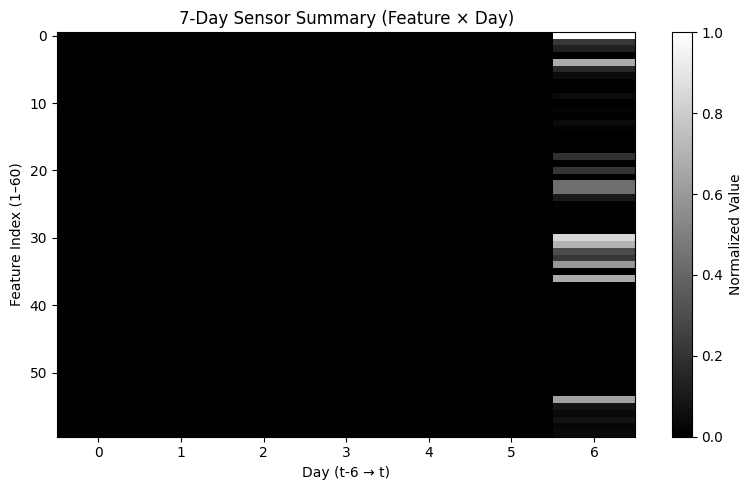

In [80]:
img_tensor = X_tensor[0, 0]  # shape: (60 features, 7 days)

plt.figure(figsize=(8, 5))
plt.imshow(img_tensor, aspect='auto', cmap='gray', vmin=0, vmax=1)
plt.title('7-Day Sensor Summary (Feature × Day)')
plt.xlabel('Day (t-6 → t)')
plt.ylabel('Feature Index (1–60)')
plt.colorbar(label='Normalized Value')
plt.tight_layout()
plt.show()

# (1) 스택 & 채널×시간 형태로 변환

In [81]:
# (1) 하루 단위 (7일 시퀀스) → (N, 60, 7)
X = np.stack(X_seq)                  # (N, 60, 7)
X_tensor = torch.from_numpy(X)      # (N, 60, 7)

# (2) CNN 입력용 채널 차원 추가: (N, 1, 60, 7)
X_tensor = X_tensor.unsqueeze(1).float()  # float32 변환 포함

# (3) y_target: (N, 6)
# object형 배열 → float형 배열로 변환
y_target = np.array(y_target, dtype=np.float32)

# 텐서 변환
y_tensor = torch.from_numpy(y_target).float()

# (2) Dataset & DataLoader

In [82]:
X_tensor.shape

torch.Size([450, 1, 60, 7])

In [83]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

y_tensor = torch.from_numpy(y_target.astype(np.float32))

ds     = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

# 3) PixleepFlow (자동 feature‐map 크기 계산)

In [84]:
class PixleepFlowMultiHead(nn.Module):
    def __init__(self, in_ch=1, H=60, W=7):
        super().__init__()
        # CNN block: Conv → ReLU → MaxPool (2회 반복)
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),     nn.ReLU(), nn.MaxPool2d(2),
        )

        # Feature map 크기 계산 (H=60 → 15, W=7 → 1)
        feat_h, feat_w = H // 4, W // 4
        flat_dim = 32 * feat_h * feat_w

        # Shared FC
        self.shared_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),
            nn.ReLU(),
        )

        # Binary tasks: Q1, Q2, Q3, S2, S3 → 5개 로짓
        self.head_bin = nn.Linear(128, 5)

        # Multi-class task: S1 → 3개 클래스 로짓
        self.head_s1 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.features(x)         # (B, 32, 15, 1)
        x = self.shared_fc(x)        # (B, 128)
        out_bin = self.head_bin(x)   # (B, 5)
        out_s1 = self.head_s1(x)     # (B, 3)
        return out_bin, out_s1

# (4) Train/Validation 분리

In [67]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# 데이터 분할 (80% train / 20% valid)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# TensorDataset & DataLoader
batch_size = 8
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


# (5) 손실/옵티마이저

In [85]:
import torch.optim as optim

bce = nn.BCEWithLogitsLoss()   # binary classification
ce  = nn.CrossEntropyLoss()    # multi-class classification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PixleepFlowMultiHead(in_ch=1, H=60, W=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# (6) 학습 루프 (n epochs)

In [86]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        bin_logits, s1_logits = model(imgs)
        y_bin = torch.cat([labels[:, :3], labels[:, 4:6]], dim=1)
        y_s1  = labels[:, 3].long()

        loss_bin = bce(bin_logits, y_bin)
        loss_s1  = ce(s1_logits, y_s1)
        loss = loss_bin + loss_s1

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_avg = train_loss / len(train_loader)

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0.0
    correct_bin = 0
    correct_s1  = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            bin_logits, s1_logits = model(imgs)
            y_bin = torch.cat([labels[:, :3], labels[:, 4:6]], dim=1)
            y_s1  = labels[:, 3].long()

            loss_bin = bce(bin_logits, y_bin)
            loss_s1  = ce(s1_logits, y_s1)
            loss = loss_bin + loss_s1
            val_loss += loss.item()

            # Binary Accuracy (Q1–Q3, S2–S3)
            bin_preds = torch.sigmoid(bin_logits) > 0.4
            correct_bin += (bin_preds == y_bin.bool()).sum().item()

            # Multi-class Accuracy (S1)
            s1_preds = torch.argmax(s1_logits, dim=1)
            correct_s1 += (s1_preds == y_s1).sum().item()

            total += y_bin.numel() + y_s1.size(0)

    val_avg = val_loss / len(val_loader)
    bin_acc = correct_bin / (len(val_ds) * 5)  # 5 binary targets
    s1_acc  = correct_s1 / len(val_ds)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_avg:.4f} | Val Loss: {val_avg:.4f} | "
          f"Bin Acc: {bin_acc:.3f} | S1 Acc: {s1_acc:.3f}")


Epoch 1/50 | Train Loss: 1.7289 | Val Loss: 1.7271 | Bin Acc: 0.604 | S1 Acc: 0.500
Epoch 2/50 | Train Loss: 1.6841 | Val Loss: 1.7141 | Bin Acc: 0.604 | S1 Acc: 0.500
Epoch 3/50 | Train Loss: 1.6559 | Val Loss: 1.7356 | Bin Acc: 0.609 | S1 Acc: 0.500
Epoch 4/50 | Train Loss: 1.6091 | Val Loss: 1.6839 | Bin Acc: 0.607 | S1 Acc: 0.456
Epoch 5/50 | Train Loss: 1.5766 | Val Loss: 1.7118 | Bin Acc: 0.607 | S1 Acc: 0.489
Epoch 6/50 | Train Loss: 1.5500 | Val Loss: 1.7091 | Bin Acc: 0.609 | S1 Acc: 0.478
Epoch 7/50 | Train Loss: 1.5157 | Val Loss: 1.6751 | Bin Acc: 0.596 | S1 Acc: 0.533
Epoch 8/50 | Train Loss: 1.4912 | Val Loss: 1.7170 | Bin Acc: 0.596 | S1 Acc: 0.511
Epoch 9/50 | Train Loss: 1.4154 | Val Loss: 1.6687 | Bin Acc: 0.613 | S1 Acc: 0.533
Epoch 10/50 | Train Loss: 1.3365 | Val Loss: 1.7370 | Bin Acc: 0.593 | S1 Acc: 0.456
Epoch 11/50 | Train Loss: 1.3122 | Val Loss: 1.8064 | Bin Acc: 0.598 | S1 Acc: 0.544
Epoch 12/50 | Train Loss: 1.2781 | Val Loss: 1.7520 | Bin Acc: 0.602 | S1 

In [71]:
torch.save(model.state_dict(), "pixleepflow_multih_head.pth")

# (7) ❗예시 예측 출력

In [87]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(loader))
    imgs, labels = imgs.to(device), labels.to(device)

    bin_logits, s1_logits = model(imgs)  # (B,5), (B,3)
    bin_probs = torch.sigmoid(bin_logits)         # (B,5)
    s1_probs  = torch.softmax(s1_logits, dim=1)   # (B,3)

    bin_preds = (bin_probs >= 0.5).int()          # (B,5)
    s1_preds  = torch.argmax(s1_probs, dim=1)     # (B,)

    # 예시 출력 (i번째 샘플)
    i = 1
    y_true = labels[i].cpu().numpy()

    print("📌 Ground Truth")
    print(f"   Q1–Q3: {y_true[:3]} | S1: {y_true[3]} | S2–S3: {y_true[4:]}")

    print("\n🔹 Binary Task (Q1,Q2,Q3,S2,S3)")
    print(f"   Logits  : {bin_logits[i].cpu().numpy()}")
    print(f"   Probs   : {bin_probs[i].cpu().numpy()}")
    print(f"   Predict : {bin_preds[i].cpu().numpy()}")

    print("\n🔹 Multi-Class Task (S1)")
    print(f"   Logits  : {s1_logits[i].cpu().numpy()}")
    print(f"   Probs   : {s1_probs[i].cpu().numpy()}")
    print(f"   Predict : {s1_preds[i].item()}")


📌 Ground Truth
   Q1–Q3: [1. 0. 1.] | S1: 1.0 | S2–S3: [1. 1.]

🔹 Binary Task (Q1,Q2,Q3,S2,S3)
   Logits  : [-0.00436505  0.51409596 -0.06203081  0.6195182   0.73183125]
   Probs   : [0.49890876 0.62576616 0.48449728 0.65010893 0.67520696]
   Predict : [0 1 0 1 1]

🔹 Multi-Class Task (S1)
   Logits  : [ 0.1448537  0.4341201 -1.6423328]
   Probs   : [0.39954004 0.53356475 0.06689521]
   Predict : 1


# 제출 파일 생성

In [88]:
# 0) sample_submission 불러오기
df_sub = pd.read_csv(
    "/content/drive/MyDrive/Sleep/ch2025_submission_sample.csv",
    parse_dates=['lifelog_date', 'sleep_date']
)

# 1) 테스트 시퀀스 생성 (7일치 하루 요약)
SEQUENCE_LENGTH = 7
X_test_seq = []

for _, row in tqdm(df_sub.iterrows(), total=len(df_sub)):
    subject_id = row['subject_id']
    lifelog_date = pd.to_datetime(row['lifelog_date'])

    seq = []
    for i in range(SEQUENCE_LENGTH):
        date = lifelog_date - pd.Timedelta(days=SEQUENCE_LENGTH - 1 - i)
        daily_feature = merge_input_daily(subject_id, date, input_dict, feature_structure)
        seq.append(daily_feature.drop(columns=['subject_id', 'date']).values[0])

    seq_array = np.stack(seq, axis=-1)  # (features, 7일)
    X_test_seq.append(seq_array)

# 2) NumPy stack & tensor 변환
X_test_np = np.stack(X_test_seq)                      # (250, features, 7)
X_test_tensor = torch.from_numpy(X_test_np).unsqueeze(1).float()  # (250, 1, features, 7)
test_ds = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

# 3) 모델 가중치 로드 & 추론
model.load_state_dict(torch.load("pixleepflow_multih_head.pth", map_location=device))
model.eval()
model.to(device)

all_bin_logits = []
all_s1_logits = []

with torch.no_grad():
    for (imgs,) in test_loader:
        imgs = imgs.to(device)
        bin_logits, s1_logits = model(imgs)  # (B,5), (B,3)
        all_bin_logits.append(bin_logits.cpu().numpy())
        all_s1_logits.append(s1_logits.cpu().numpy())

# 4) 후처리 및 예측 결과 저장
all_bin_logits = np.vstack(all_bin_logits)  # (250,5)
all_s1_logits = np.vstack(all_s1_logits)    # (250,3)

bin_probs = 1 / (1 + np.exp(-all_bin_logits))  # sigmoid 변환

df_sub['Q1'] = (bin_probs[:, 0] >= 0.5).astype(int)
df_sub['Q2'] = (bin_probs[:, 1] >= 0.5).astype(int)
df_sub['Q3'] = (bin_probs[:, 2] >= 0.5).astype(int)
df_sub['S1'] = np.argmax(all_s1_logits, axis=1)
df_sub['S2'] = (bin_probs[:, 3] >= 0.5).astype(int)
df_sub['S3'] = (bin_probs[:, 4] >= 0.5).astype(int)

# 5) 저장
out_path = "/content/drive/MyDrive/Sleep/submission_file/submission9.csv"
df_sub.to_csv(out_path, index=False)
print(f"▶ {out_path} 생성 완료")

100%|██████████| 250/250 [00:56<00:00,  4.40it/s]

▶ /content/drive/MyDrive/Sleep/submission_file/submission11.csv 생성 완료


In [74]:
df_sub.shape

(250, 9)